In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import hickle

from ase.io import read

import torch
torch.set_default_dtype(torch.float64)
import numpy as np

from mlelec.data.dataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
# from mlelec.utils._utils import blocks_to_matrix_opt as blocks_to_matrix
from mlelec.utils.pbc_utils import  blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis

import metatensor.torch as mts
from metatensor.learn import DataLoader

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

from IPython.utils import io as ipy_io


/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
}

device = 'cpu'

In [4]:
max_radial  = 12
max_angular = 6
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 4

In [5]:
def compute_eigval_vec(dataset, batch, Hk, return_rho = False, return_eigenvectors = False):
    eig = []
    rho = []
    eigvec = []
    for A, H, S in zip(batch.sample_id, Hk, batch.overlap_realspace):
        # Compute eigenvalues and eigenvectors
        # eigvals, eigvecs = symeig(Ax, M = Mx)
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M = xitorch.LinearOperator.m(S))
        if return_rho:
            frame = dataset.structures[A]
            natm = len(frame)
            ncore = sum(dataset.ncore[s] for s in frame.numbers)
            nelec = sum(frame.numbers) - ncore
            occ = torch.tensor([2.0 if i < nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            # occ = torch.tensor([2.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            rho.append(torch.einsum('n,...in,...jn->ij...', occ, C, C.conj()))
        eig.append(eigvals)
        if return_eigenvectors:
            eigvec.append(C)

    to_return = [eig]
    if return_rho:
        try:
            rho = torch.stack(rho)
        except:
            pass
        to_return.append(rho)
    if return_eigenvectors:
        try:
            eigvec = torch.stack(eigvec)
        except:
            pass
        to_return.append(eigvec)
    return tuple(to_return)

def compute_ard_vec(dataset, batch, HT, device, overlap = None):
    basis = dataset.basis
    ard_ = []
    eig = []
    Cs = []
    rhos = []

    overlap = batch.overlap_realspace if overlap is None else overlap
    
    for A, H, S in zip(batch.sample_id, HT, overlap):
        frame = dataset.structures[A]
        natm = len(frame)
        ncore = sum(dataset.ncore[s] for s in frame.numbers)
        nelec = sum(frame.numbers) - ncore
        split_idx = [len(basis[s]) for s in frame.numbers]
        needed = True if len(np.unique(split_idx)) > 1 else False
        
        max_dim = np.max(split_idx)
        
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S), return_eigenvectors = True) # Has shape = (n_k, N, N)
        
        occ = torch.tensor([2.0 if i < nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
        P = torch.einsum('n,...in,...jn->ij...', occ, C, C.conj())
        rhos.append(P)
        
        slices = torch.split(P, split_idx, dim=0)
        blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
        blocks_flat = [block for sublist in blocks for block in sublist]
        
        if needed:
            squared_blocks = []
            for block in blocks_flat:
                pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))
                squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
                squared_blocks.append(squared_block)
            blocks_flat = squared_blocks


        ard_.append(torch.stack(blocks_flat).norm(dim=(1,2)))
        eig.append(eigvals)
        Cs.append(C)

    try:
        ard_ = torch.stack(ard_)
    except:
        pass
    try:
        eig = torch.stack(eig)
    except:
        pass
    try:
        rhos = torch.stack(rhos)
    except:
        pass
    try:
        Cs = torch.stack(Cs)
    except:
        pass
    
    return eig, ard_, Cs, rhos

In [6]:
import os

os.environ["PYSCFAD_BACKEND"] = "torch"

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order

Using PyTorch backend.


In [7]:
def compute_dipole_moment(frames, fock_predictions, overlaps, basis = 'sto-3g'):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame, basis = basis)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )
        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

# PROJECT from one basis to another 

In [8]:
workdir = '../examples/data/water_1000'
nstruc = 200
frames = read(f'{workdir}/water_1000.xyz',f':{nstruc}')
fock = hickle.load(f'{workdir}/sto-3g/fock.hickle')[:nstruc]
over = hickle.load(f'{workdir}/sto-3g/overlap.hickle')[:nstruc]
fock_def2 = torch.from_numpy(np.load(f'{workdir}/def2svp/focks.npy', allow_pickle = True)[:nstruc].astype(np.float64))
over_def2 = torch.from_numpy(np.load(f'{workdir}/def2svp/overlaps.npy', allow_pickle=True)[:nstruc].astype(np.float64))

In [9]:
qmdata = QMDataset(frames = frames, 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=fock.clone(),
                   overlap_realspace=list(over.clone()),
                   device = device, 
                   orbs = orbitals['sto-3g'], 
                   # orbs = orbitals['def2svp'], 
                   orbs_name = 'sto-3g'
                   # orbs_name = 'def2svp'
                )

In [10]:
qmdata_def2 = QMDataset(frames = frames, 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=fock_def2.clone(),
                   overlap_realspace=list(over_def2.clone()),
                   device = device, 
                   # orbs = orbitals['sto-3g'], 
                   orbs = orbitals['def2svp'], 
                   # orbs_name = 'sto-3g'
                   orbs_name = 'def2svp'
                )

In [11]:
max_radial  = 12
max_angular = 6
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 4

In [12]:
mldata = MLDataset(qmdata_def2, 
                   item_names = ['overlap_blocks', 'fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'density_matrix', 'atom_resolved_density'],
                   # features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   orbitals_to_properties = True,
                   train_frac = 0.8,
                   val_frac = 0.2,
                  )

cpu pair features
cpu single center features
cpu single center features
Features set


/home/pegolo/Software/mlelec/src/mlelec/data/mldataset.py:264: UserWarning: Target density_matrix is not implemented! Skipping it
  warnings.warn(f"Target {name} is not implemented! Skipping it")


Items set


In [13]:
mldata._compute_model_metadata(qmdata)

In [14]:
#mldata._split_indices(train_frac = 0.8, val_frac = 0.2)
#mldata._split_items(mldata.train_frac, mldata.val_frac, mldata.test_frac)

In [15]:
dl = DataLoader(mldata.train_dataset, batch_size = 10, collate_fn = mldata.group_and_join)

In [16]:
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
loss_fn = Eigval_loss #L2_loss #_meanzero

In [17]:
from mlelec.utils.pbc_utils import blocks_to_matrix

In [21]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = qmdata.structures, 
                            orbitals = qmdata.basis, 
                            device = device,
                            nhidden = 4, 
                            nlayers = 1,
                            activation = 'SiLU',
                           apply_norm = True
                           )
model = model.double()
NEPOCHS = 0

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [23]:
nepoch = 286
losses = []
losses_e = []
losses_t = []
losses_evec = []
par = 0.5
alpha = 1 #(1 + par)
beta = 1 #(1 - par**2)
for epoch in range(NEPOCHS,NEPOCHS+nepoch):

    epoch_loss = 0
    epoch_loss_e = 0
    epoch_loss_evec = 0
    epoch_loss_ard = 0
    eig_sum = 0
    

    # Train against real space targets
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)

        # loss = L2_loss(pred, batch.fock_blocks)
        
        HT = blocks_to_matrix(pred, qmdata, detach = False) #, structure_ids=batch.sample_id)
        HT = [HT[i][0,0,0] for i in batch.sample_id]

        # pred_eigvals, pred_C = compute_eigval_vec(qmdata, batch, HT, return_eigenvectors = True)
        pred_eigvals, pred_ard, pred_C, _ = compute_ard_vec(qmdata, batch, HT, 'cpu', overlap = [qmdata.overlap_realspace[i] for i in batch.sample_id])

        loss_e = loss_fn(pred_eigvals[:, :5], batch.eigenvalues[:, :5])
        loss_ard = torch.sum((pred_ard - batch.atom_resolved_density)**2)
        # pred_ev_3 = torch.norm(pred_C[:, :, :5], dim = (1,2))**3
        # targ_ev_3 = torch.norm(batch.eigenvectors[:, :, :5], dim = (1,2))**3
        # pred_ev_2 = torch.norm(pred_C[:, :, :5], dim = (1,2))**2
        # targ_ev_2 = torch.norm(batch.eigenvectors[:, :, :5], dim = (1,2))**2
        # pred_ev_1 = torch.norm(pred_C[:, :, :5], dim = (1,2))
        # targ_ev_1 = torch.norm(batch.eigenvectors[:, :, :5], dim = (1,2))
        pred_ev_0 = torch.norm(pred_C[:, :, :5], dim = (1))
        targ_ev_0 = torch.norm(batch.eigenvectors[:, :, :5], dim = (1))
        loss_evec = torch.sum((pred_ev_0 - targ_ev_0)**2)
        # loss_evec = torch.sum((pred_ev_2 - targ_ev_2)**2) + torch.sum((pred_ev_1 - targ_ev_1)**2) + torch.sum((pred_ev_0 - targ_ev_0)**2) + torch.sum((pred_ev_3 - targ_ev_3)**2)

        # loss = loss_evec + loss_e
        loss = loss_ard + loss_e + loss_evec
        # loss =  loss_e
        
        
        # pred_eigvals = compute_eigval_vec(qmdata, batch, HT, return_rho=False)
        # pred_eigvals, pred_rho = compute_eigval_vec(qmdata, batch, HT, return_rho=True)
        # trace_loss = sum((torch.einsum('ji...,nij...->n...', pred_rho[Ab] - batch.density_matrix[Ab].real, targets[A])**2).sum() for Ab, A in enumerate(batch.sample_id)) #/tar_var
        # trace_loss_2 = sum(((torch.einsum('ji...,ij...->...', pred_rho[Ab], HT[Ab]) - torch.einsum('ji...,ij...->...', batch.density_matrix[Ab].real, batch.fock_realspace[Ab]))**2).sum() for Ab, A in enumerate(batch.sample_id))
        # eig_sum += sum(torch.stack(pred_eigvals)[:,:5].sum(dim=1) - batch.eigenvalues[:,:5].sum(dim=1)).item()

        # rho_loss = (torch.stack(pred_rho) - batch.density_matrix.real).norm()**2
        
        
        # epoch_loss_t += #trace_loss.item() + trace_loss_2.item()
        # loss = loss_e + trace_loss 
        # loss = alpha*loss_e + beta*trace_loss #  + loss_fn(pred_ard, batch.atom_resolved_density)
        # loss = loss_e/(epoch_loss_e*5e-1) + trace_loss/(epoch_loss_t*8e-1)
        # loss = loss_e + rho_loss #trace_loss # + trace_loss_2 #/(epoch_loss_t*5e-2)

        # loss = L2_loss(pred, batch.fock_blocks)
        # loss = loss_e + 0.1*(torch.sum(torch.stack(pred_eigvals)[:,:5])-torch.sum(batch.eigenvalues[:,:5]))**2 + 0.001*(torch.sum(torch.stack(pred_eigvals)[:,:5]**2)-torch.sum(batch.eigenvalues[:,:5]**2))**2
        
        loss.backward()
        optimizer.step()

        epoch_loss_e += loss_e.item()
        epoch_loss_evec += loss_evec.item()
        epoch_loss_ard += loss_ard.item()
        # epoch_loss_t += rho_loss.item()
        epoch_loss += loss.item()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), .1)
    # par = epoch_loss_e/2/epoch_loss_t
    # alpha = (1 + par) if epoch_loss_e > epoch_loss_t else (1 - par**2)
    # beta = (1 + par) if epoch_loss_e <= epoch_loss_t else (1 - par**2)
    # par = epoch_loss_e/2/epoch_loss_t if epoch_loss_e > epoch_loss_t else epoch_loss_t/2/epoch_loss_e
    # alpha = 1+par
    # if epoch>100:
    #     alpha = epoch/1000
    # beta = 1-par**2
    # if epoch ==0: 
    #     alpha = 1/epoch_loss_e 
    #     beta = 1/epoch_loss_t
    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    losses_e.append(epoch_loss_e)
    losses_evec.append(epoch_loss_evec)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {epoch_loss:>15.10f} {np.sqrt(epoch_loss_e/7/160):>15.10f} {np.sqrt(epoch_loss_evec/5/160):>15.10f} {np.sqrt(epoch_loss_ard/160):>15.10f} ")#{eig_sum:>15.10f}")
        # print(f"Epoch {epoch:>7d}, train loss {np.sqrt(epoch_loss):>15.10f} {np.sqrt(epoch_loss_e):>15.10f} {np.sqrt(epoch_loss_t):>15.10f} {par:>15.10f} {}")

Epoch       0, train loss 61532.7779177006    7.2430877775    0.3569043823    4.0873847907 
Epoch       1, train loss 31615.1413838210    4.9790804672    0.3942113748    4.8248237811 
Epoch       2, train loss 9629.5143713809    2.3454669315    0.3639764145    4.5840554951 
Epoch       3, train loss 6187.0614759727    1.7799099724    0.3130171645    4.0003348522 
Epoch       4, train loss 4248.6800126652    1.3335042751    0.2886104607    3.7000181793 
Epoch       5, train loss 3327.7726704901    1.0169349041    0.2843411845    3.6270143989 
Epoch       6, train loss 2784.6397495895    0.7373784872    0.2892201109    3.6303812249 
Epoch       7, train loss 2420.1010729521    0.4460355529    0.2938640454    3.6470833990 
Epoch       8, train loss 2282.8665817949    0.3171760352    0.2910665066    3.6249293950 
Epoch       9, train loss 2221.3919846761    0.2509359018    0.2898653284    3.6087128694 
Epoch      10, train loss 2187.7715090029    0.2106428270    0.2892488818    3.597868056

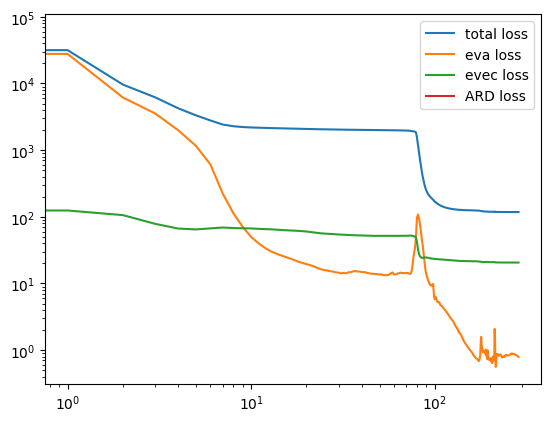

In [18]:
plt.loglog(losses, label="total loss")
plt.loglog(losses_e, label="eva loss",)
plt.loglog(losses_evec, label="evec loss")
plt.loglog(losses_t, label="ARD loss")
plt.legend()

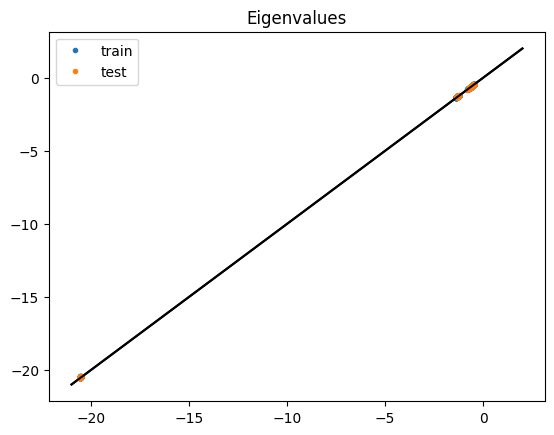

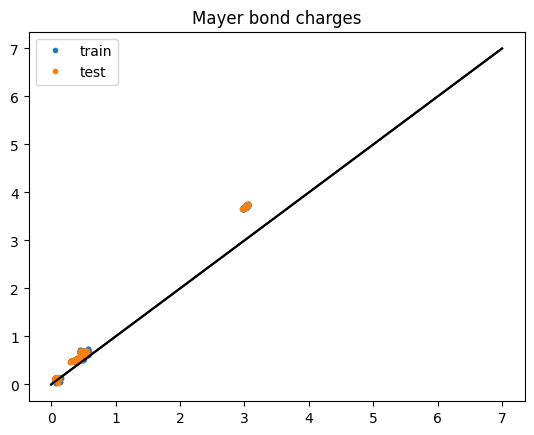

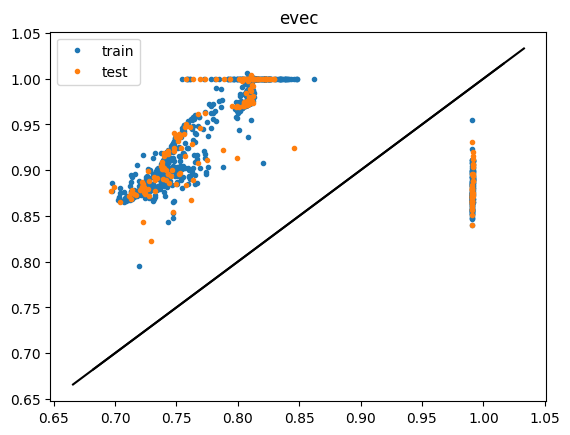

In [19]:
# n = 100
# targets = [rnd_herm(n, f.shape[0]) for f in mldata.items['fock_realspace']] 

val_dl = DataLoader(mldata.val_dataset, batch_size = len(mldata.val_dataset), collate_fn=mldata.group_and_join)
train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.train_dataset), collate_fn=mldata.group_and_join)

fig_e, ax_e = plt.subplots()
# fig_r, ax_r = plt.subplots()
fig_a, ax_a = plt.subplots()
fig_evec, ax_evec = plt.subplots()
# fig_rho, ax_rho = plt.subplots()

data = {}
for dl_, lbl in zip([train_dl, val_dl], ['train', 'test']):
    batch = next(iter(dl_))
    pred = model(batch.features, mldata.model_metadata)

    HT = blocks_to_matrix(pred, qmdata, detach = False) #, structure_ids=batch.sample_id)
    HT = [HT[i][0,0,0] for i in batch.sample_id]
    
    pred_eigvals, pred_ard, pred_eigvec, pred_rho = compute_ard_vec(qmdata, batch, HT, device, overlap = [qmdata.overlap_realspace[i] for i in batch.sample_id])

    ax_e.plot(batch.eigenvalues[:,:5].flatten(), pred_eigvals[:,:5].detach().flatten(), '.', label = lbl)
    ax_e.plot([-21, 2], [-21, 2], 'k')
    ax_e.set_title('Eigenvalues')
    ax_e.legend()

    ax_a.plot(batch.atom_resolved_density.flatten(), pred_ard.detach().flatten(), '.', label = lbl)
    ax_a.plot([0,7], [0,7], 'k')
    ax_a.set_title('Mayer bond charges')
    ax_a.legend()

    nn = 1
    pred_evn, targ_evn = torch.norm(pred_eigvec[:, :, :5], dim = (1))**nn, torch.norm(batch.eigenvectors[:, :, :5], dim = (1))**nn
    
    ax_evec.plot(targ_evn.flatten(), pred_evn.detach().flatten(), '.', label = lbl)
    xmin, xmax = ax_evec.get_xlim()
    ymin, ymax = ax_evec.get_ylim()
    xmin = np.min([xmin,ymin])
    xmax = np.max([xmax,ymax])
    ax_evec.plot([xmin,xmax], [xmin,xmax], 'k')
    ax_evec.set_title('evec')
    ax_evec.legend()

In [20]:
batch = next(iter(val_dl))
print(batch.sample_id)
dl_frames = [qmdata.structures[A] for A in batch.sample_id]

pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, qmdata, detach = True)
HT = [HT[i][0,0,0] for i in batch.sample_id]

fock_predictions = torch.stack(HT)

fock_predictions = unfix_orbital_order(
    fock_predictions,
    dl_frames,
    qmdata.basis,
)

fock_targets = unfix_orbital_order(
    batch.fock_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

over_large = unfix_orbital_order(
    batch.overlap_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

over_small = unfix_orbital_order(
    torch.stack([qmdata.overlap_realspace[i] for i in batch.sample_id]),
    dl_frames,
    qmdata.basis,
)

with ipy_io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_large,
        qmdata_def2.basis_name
    )

with ipy_io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_small,
        qmdata.basis_name
    )

(160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199)


In [22]:
fock_sto3g = unfix_orbital_order(
    torch.stack([qmdata.fock_realspace[i] for i in batch.sample_id]),
    dl_frames,
    qmdata.basis,
)

with ipy_io.capture_output():
    dipole_sto3g = compute_dipole_moment(
        dl_frames,
        fock_sto3g,
        over_small,
        qmdata.basis_name
    )

In [25]:
dipole_predictions[0], dipole_sto3g[0], dipole_targets[0]

(tensor([-4.8616e-01, -3.3301e-08,  2.4094e+00], grad_fn=<SelectBackward0>),
 tensor([-3.3735e-01,  6.5358e-07,  1.6719e+00], grad_fn=<SelectBackward0>),
 tensor([-4.2425e-01,  2.5117e-07,  2.1026e+00], grad_fn=<SelectBackward0>))

In [27]:
fock_predictions[0]

tensor([[-4.6768e-01, -1.2473e+00,  1.2991e-01, -4.4048e-07, -6.4382e-01,
          1.0420e+00,  1.0420e+00],
        [-1.2473e+00,  4.2536e+00, -4.6426e-01,  1.0726e-06,  2.3009e+00,
         -4.3337e+00, -4.3337e+00],
        [ 1.2991e-01, -4.6426e-01, -8.6965e-01, -1.8784e+00, -2.9845e-01,
          4.0589e+00, -3.3033e+00],
        [-4.4048e-07,  1.0726e-06, -1.8784e+00, -9.9288e+00, -3.7901e-01,
          1.8402e+01, -1.8402e+01],
        [-6.4382e-01,  2.3009e+00, -2.9845e-01, -3.7901e-01,  5.4924e-01,
         -1.1295e+00, -2.6150e+00],
        [ 1.0420e+00, -4.3337e+00,  4.0589e+00,  1.8402e+01, -1.1295e+00,
          9.6552e+00, -5.4501e+00],
        [ 1.0420e+00, -4.3337e+00, -3.3033e+00, -1.8402e+01, -2.6150e+00,
         -5.4501e+00,  9.6552e+00]])

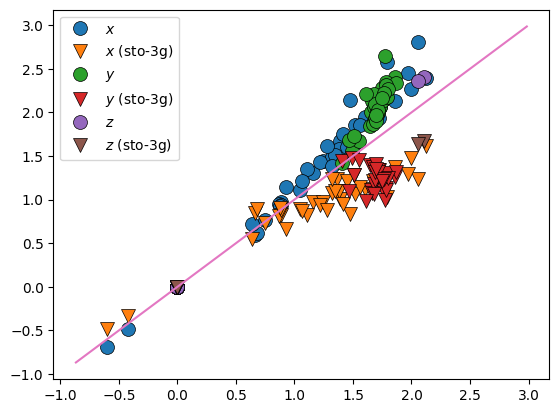

In [23]:
for i, x in enumerate(['$x$', '$y$', '$z$']):
    plt.plot(dipole_targets[:,i].flatten().detach().cpu(), dipole_predictions[:,i].flatten().detach().cpu(), 'o',
             markeredgewidth = 0.5,
             markeredgecolor = 'k',
             markersize = 10, 
             label = x, 
             alpha = 1)
    plt.plot(dipole_targets[:,i].flatten().detach().cpu(), dipole_sto3g[:,i].flatten().detach().cpu(), 'v', 
             markeredgewidth = 0.5,
             markeredgecolor = 'k',
             markersize = 10, 
             label = x + ' (sto-3g)', 
             alpha = 1)
plt.legend()

xm, xM = plt.xlim()
ym, yM = plt.ylim()
m = np.min([xm,ym])
M = np.max([xM,yM])
plt.plot([m,M], [m,M])

Text(0.5, 1.0, 'Indirect training from def2-svp to a STO-3G-like model.\nTargets: eigenvalues; ARD; eigenvector norms over AOs\nTest set contains 50 water molecules')

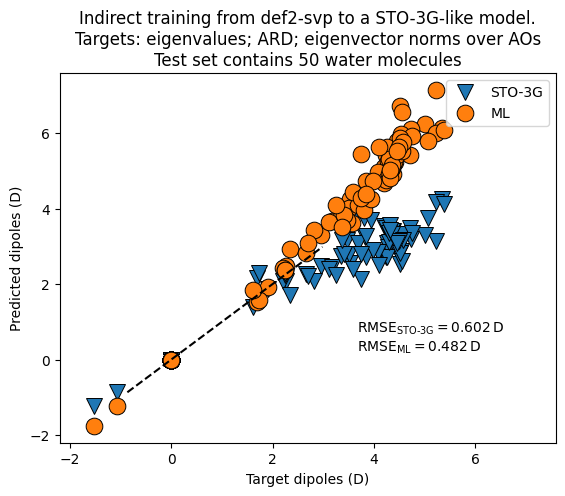

In [24]:
from ase.units import Bohr, Debye
au_to_debye = Bohr/Debye

ms = 12
mew = .7

fig, ax = plt.subplots()

x = dipole_targets.flatten().detach().cpu() * au_to_debye
y_sto3g = dipole_sto3g.flatten().detach().cpu() * au_to_debye
y_ml = dipole_predictions.flatten().detach().cpu() * au_to_debye

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()

xm, xM = ax.get_xlim()
ym, yM = ax.get_ylim()
ax.plot([m,M], [m,M], '--k')
m = np.min([xm,ym])
M = np.max([xM,yM])
ax.set_xlim(m, M)
ax.set_ylim(m, M)

ax.text(0.6, 0.3, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$D', transform = ax.transAxes, ha = 'left')
ax.text(0.6, 0.25, f'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$D', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target dipoles (D)')
ax.set_ylabel('Predicted dipoles (D)')

ax.set_title('Indirect training from def2-svp to a STO-3G-like model.\nTargets: eigenvalues; ARD; eigenvector norms over AOs\nTest set contains 50 water molecules')